### Classifying Types of Raisins
Group: Radman Avakoli, Kori Huen, Hailey Han, Marcus Liang

Raisins are nutrient-dense dried grapes that are produced by a variety of grapes and drying processes which makes them look dark and wrinkly. Since the physical features of different grapes look somewhat similar, is the kind of grape used to make the raisin still identifiable based on morphological features? We will analyze and use a dataset of 900 raisin observations classified as two levels (Kesimen and Besni) to see if we are able to correctly predict other unclassified raisin types based on their morphological features.

### Preliminary exploratory data analysis

In [1]:
### loading libraries 
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#loading data
raisin_data <- read_csv("https://raw.githubusercontent.com/radmantvk/DSCI-Project/main/Raisin_Dataset.csv")

# converting Class to a factor
raisin_data <- raisin_data %>%
    mutate(Class = as_factor(Class))

# viewing the dataframe varibales and the top 3 observations
head(raisin_data, n=3)

Parsed with column specification:
cols(
  Area = col_double(),
  MajorAxisLength = col_double(),
  MinorAxisLength = col_double(),
  Eccentricity = col_double(),
  ConvexArea = col_double(),
  Extent = col_double(),
  Perimeter = col_double(),
  Class = col_character()
)



Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen


**Table 1:** Raw Raisin Data

The data is loaded well and looks tidy!
__Variable Definitions:__

* Area: number of pixels within the boundaries of the raisin

* Perimeter: distance between the boundaries of the raisin and the pixels around it

* MajorAxisLength: Gives the length of the main axis (longest line that can be drawn on the raisin)

* MinorAxisLength: Gives the length of the small axis (shortest line that can be drawn on the raisin)

* Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins

* ConvexArea: Area of an imaginary convex formed around the raisin

* Extent: ratio of the region formed by the raisin to the total pixels in the bounding box

* Class: Kecimen and Besni raisin


### Methods
* Use K-nearest neighbor classification algorithm (it is simple, intuitive, and makes little assumptions about how the data looks like)
* Choose predictors
* `set.seed` for reproducibility
* split data into train and test set (leaving test set untouched until the final accuracy prediction)
* Tune classifier: Pick the right parameter (K) using cross-validation
 * use vfold_cv() for shuffling and stratifying train data
 * create model and recipe + add them to the workflow
 * use `tune`, `tune_grid`, and `collect_metrics` to observe mean accuracies
 * use a line graph to visualize what k to choose
 * consider under and overfitting
* Preprocess:
 * create K-nearest neighbor model with our chosen K
 * create recipe, centering predictors
* Create classifier
 * combine model and recipe in a workflow and train the model
* measure the accuracy of classifier by predicting the test set using the classifier
* Use the trained model and `predict` function to classify new observations

__Choosing Predictors:__
Lets use visualization to further understand a relationship between our variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



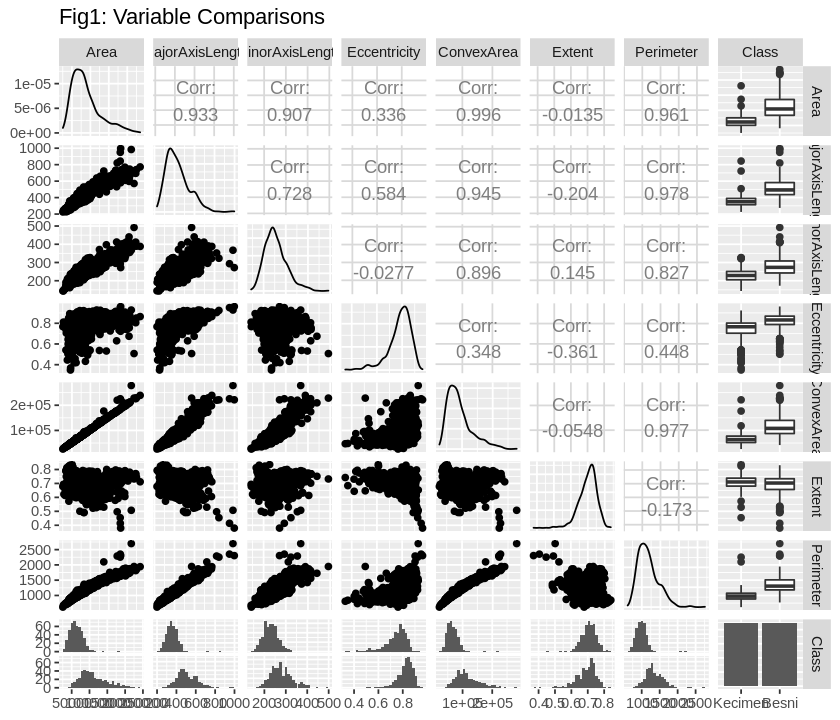

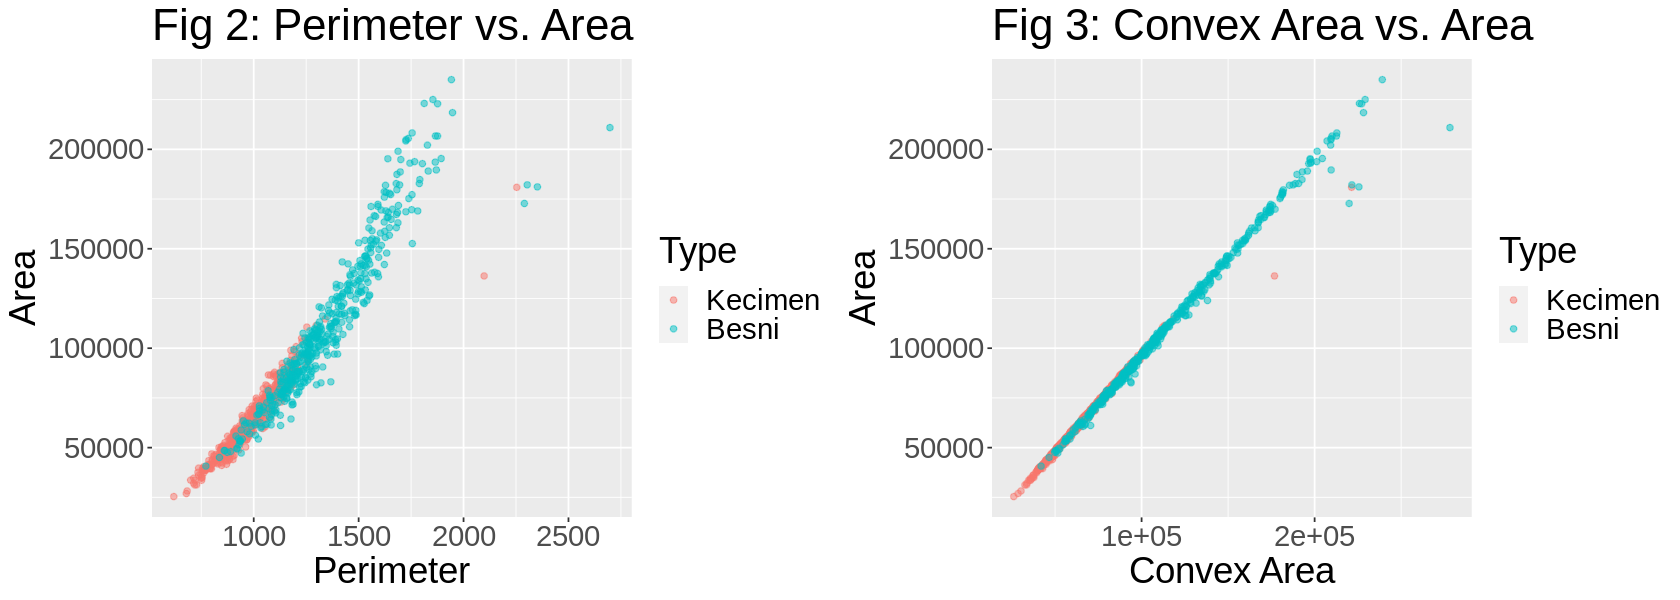

In [3]:
options(repr.plot.width = 7, repr.plot.height = 6)
raisin_pair <- ggpairs(raisin_data) +
    ggtitle("Fig1: Variable Comparisons")
raisin_pair

# raisin_plot1 <- raisin_data %>%
#     ggplot(aes(x = MajorAxisLength, y = MinorAxisLength, color = Class)) + 
#     geom_point(alpha = 0.5) +
#     labs(x = "Major Axis Length", y = "Minor Axis Length", color = "Type") +
#     ggtitle("Fig 2: Major vs. Minor Axes Lengths") + 
#     theme(text = element_text(size=22))

raisin_plot1 <- raisin_data %>%
    ggplot(aes(x = Perimeter, y = Area, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Perimeter", y = "Area", color = "Type") +
    ggtitle("Fig 2: Perimeter vs. Area") + 
    theme(text = element_text(size=22))

raisin_plot2 <- raisin_data %>%
    ggplot(aes(x = ConvexArea, y = Area, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Convex Area", y = "Area", color = "Type") +
    ggtitle("Fig 3: Convex Area vs. Area") + 
    theme(text = element_text(size=22))

options(repr.plot.width = 14, repr.plot.height = 5)
plot_grid(raisin_plot1, raisin_plot2, ncol = 2)

We will be using `MajorAxisLength` and `MinorAxisLength` variables as our predictors for classification of raisins. This is because these are the two most distinct and straightforward variables that are easily obtainable without requiring photos of raisins for data collection (no pixels involved). Having to take pictures of individual raisins to classify them and then image-processing them is tedious, so we prefer not to use predictors `Eccentricity` and `Extent`. As can be seen in the above figures, variables such as `Area` and `Perimeter` or `Area` and `ConvexArea` are too closely dependent and related to one another to include as separate predictors. So this classification will be much more simpler, intuitive, practical and easily reproducable if we can classify raisins only using major and minor axes' lengths. This way, a simple machine can readily collect this data on new observations, potentially putting our model into real use! It is also notable that having more predictors doesn't always improve our classifier.

In [4]:
# selecting variables of interest, discarding the rest
raisin_data <- raisin_data %>%
    select(MajorAxisLength, MinorAxisLength, Class)

# Setting seed for reproducibility
set.seed(33)

# spliting the data (with %75 of observations used for training data and 25% for testing with an even proportion between Class levels)
raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)

# getting a summary of our training observations
train_summary <- raisin_train %>%
    group_by(Class) %>%
    summarize(major_axis_mean_length = mean(MajorAxisLength, na.rm = TRUE), 
              minor_axis_mean_length = mean(MinorAxisLength, na.rm = TRUE),
             count = n()
             )

# scaling the plot width and height
options(repr.plot.width = 13, repr.plot.height = 12)

# Creating a scatter plot to visualize a pattern of classification considering different minor and major axes lengths
raisin_plot <- raisin_train %>%
    ggplot(aes(x = MajorAxisLength, y = MinorAxisLength, color = Class)) + 
    geom_point() +
    labs(x = "Major Axis Length", y = "Minor Axis Length", color = "Type") +
    ggtitle("Fig 4: Major vs. Minor Axes Lengths") + 
    theme(text = element_text(size=22))

train_summary

`summarise()` ungrouping output (override with `.groups` argument)



Class,major_axis_mean_length,minor_axis_mean_length,count
<fct>,<dbl>,<dbl>,<int>
Kecimen,353.8083,229.7986,338
Besni,510.8375,278.3476,338


**Table 2:** Sample of Kecimen and Besni Raisin Parameters

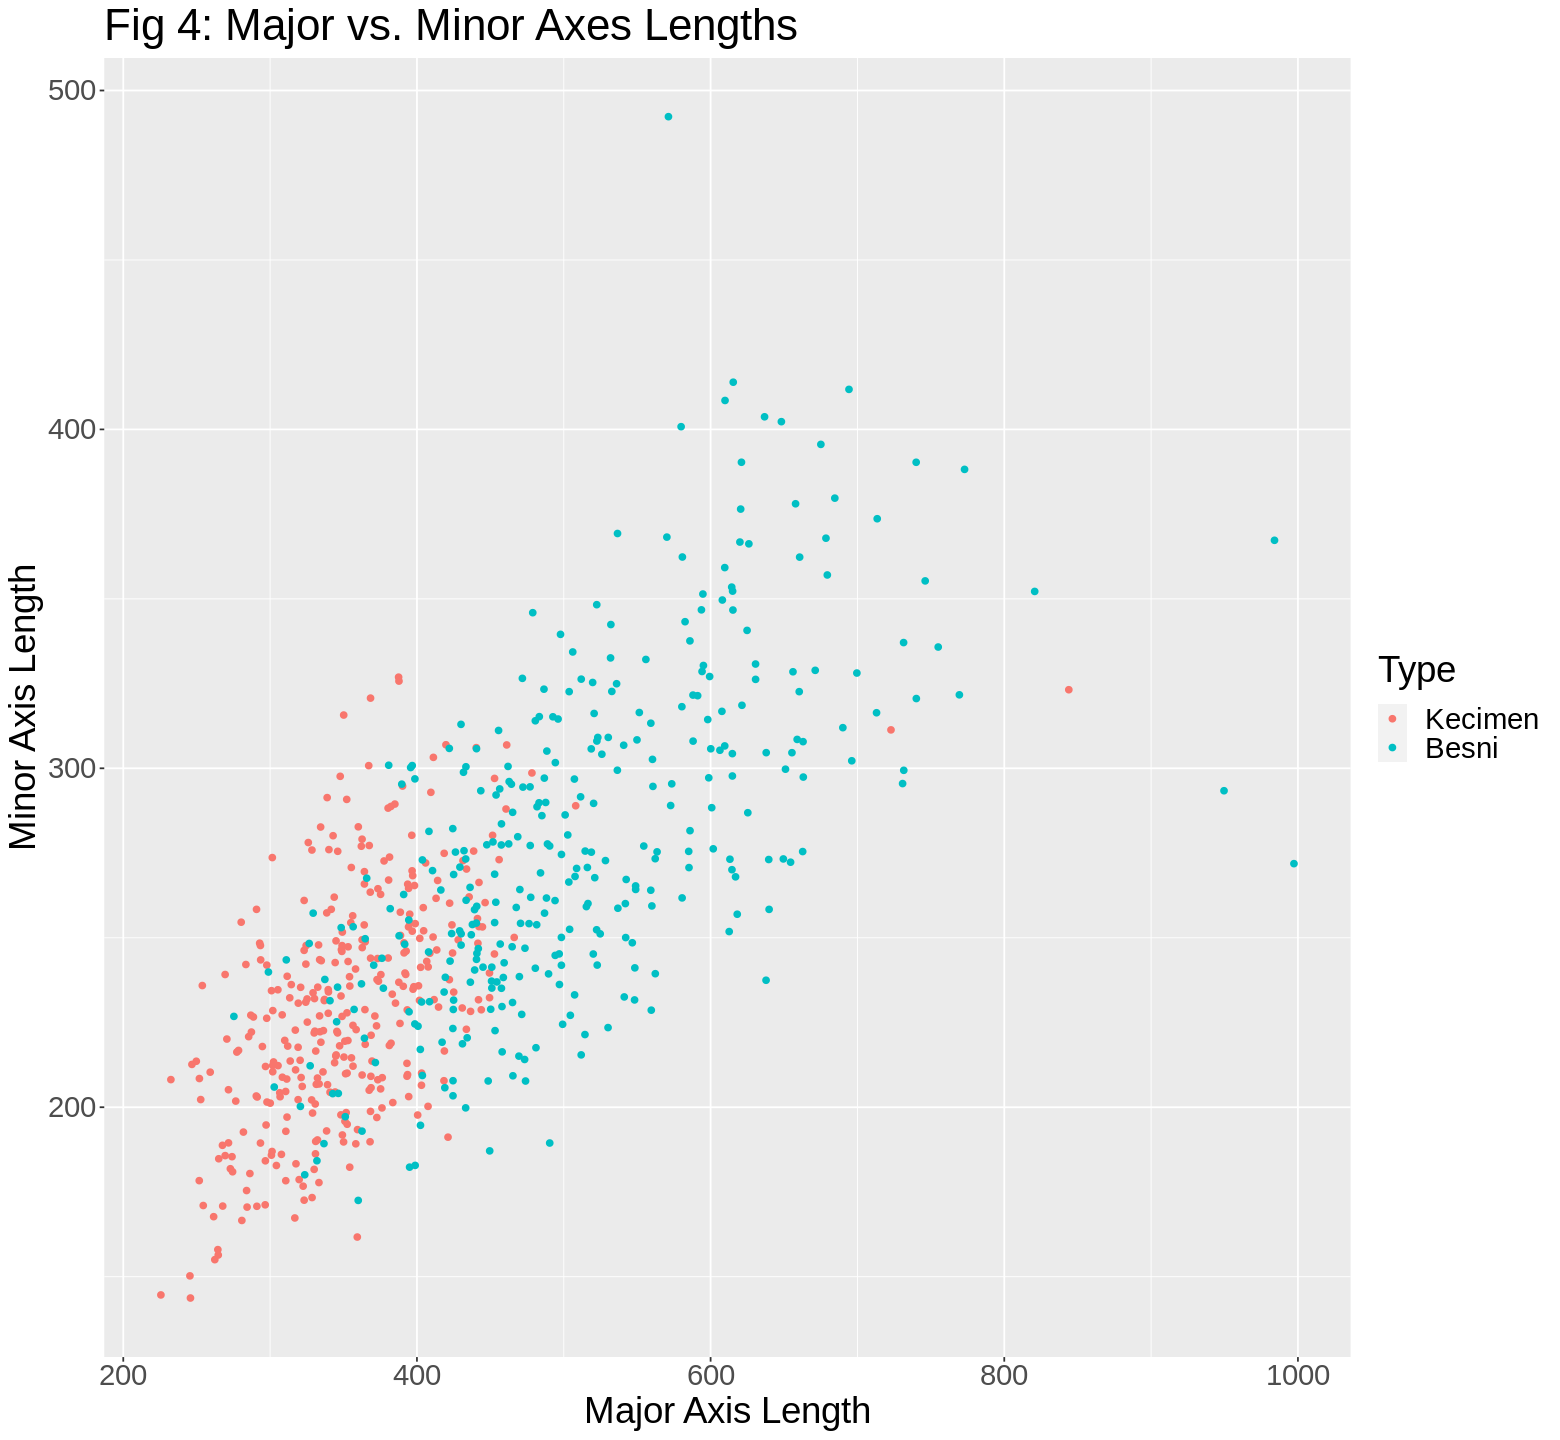

In [5]:
raisin_plot

As can be seen in the table, there s a vivid pattern and correlation between Kecimen and Besni raisins in terms of their mean length of the major and minor axes which is promising. Figure 4 also shows a visible pattern and relationship between the 2 raisins based on their minor and major axes lengths. We can observe that kecimen raisins have relatively shorter minor and major axes, and kecimen raisins have a higher minor axis length (kecimen are wider) near the region where observations have a major axis length of 400. These are good signs that we have chosen promising predictors to use for classification! In addition, the `count` column shows that our class levels are balanced, so both class levels have a fair voting power for predicting new observations and rebalancing isn't needed!

__Tune Classifier:__ Choosing a K (# of nearest neighbors) for our model using cross-validation

In [6]:
# Setting seed for reproducibility
set.seed(33)

# Build a knn-classification model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Build a recipe, specifying class label and predictors
# standardize and scale to ensure all data observations will be on a comparable scale and contribute equal shares for calculation of the distance between points
recipe <- recipe(Class ~ ., data = raisin_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Split up training data into 5 folds for cross-validation
raisin_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

# specifying the range of K values to consider
k_vals <- tibble(neighbors = seq(from = 1, to = 60))

# add model and recipe to the workflow, fit the model for all k_vals, get metrics and filter accur
raisin_results <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = k_vals)

# Get metrics and filter accuracies
raisin_results <- raisin_results %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

max_accuracies <- raisin_results %>% filter(mean == max(mean))
max_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.8519535,5,0.01626558,Model19
20,accuracy,binary,0.8519535,5,0.01626558,Model20
21,accuracy,binary,0.8519535,5,0.01487672,Model21
22,accuracy,binary,0.8519535,5,0.01487672,Model22


**Table 3:** Top accuracy for each k value

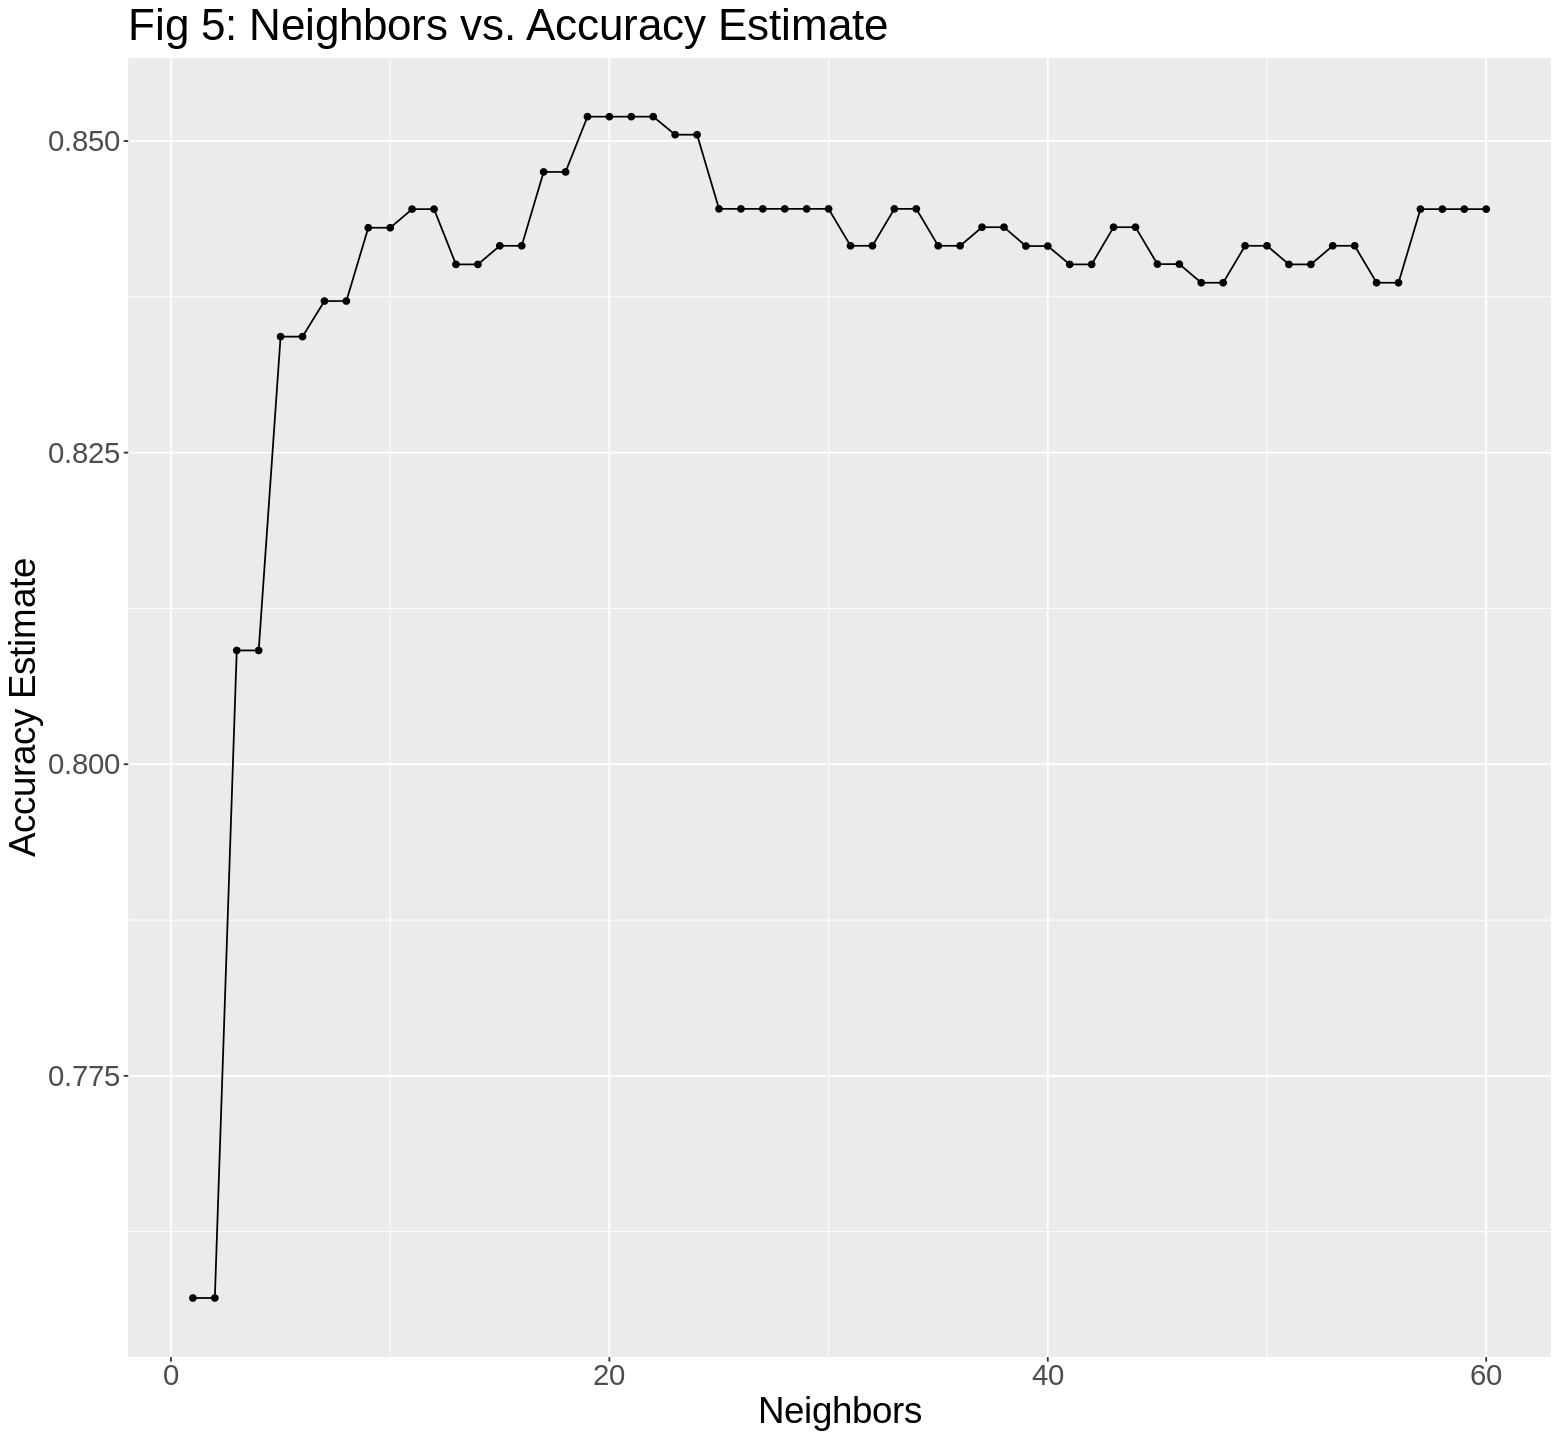

In [7]:
# Visualize what K to choose using a line graph:
accuracy_vs_k <- ggplot(raisin_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle("Fig 5: Neighbors vs. Accuracy Estimate") + 
  theme(text = element_text(size=22))
accuracy_vs_k

The goal of choosing the best K to incorporate into our model is to achieve a model that follows the overall trend from the training data (not too noisy and not too smooth). Looking at `raisin_max` tibble, we see that neighbors ranging between 19 and 22 yields the highest accuracy (85.2%). We can similarly observe this range to be at the peak of the line graph from Figure 5. If we pick the middle value (20) as our K, we can observe that the accuracy estimate does not fluctate by much if we picked a different K close to 20 (still over 84% accuracy on nearby points). 

Other notable points about picking 20 as our K:
* Suffering from overfitting is unlikely as the model will not be influenced too much by the training model with due to the averaging effect of 20 nearby observations
* Suffering from underfitting is unlikely since we did not pick an extremly large k value
* 20 is not too large to make predictions too expensive

In [8]:
# retrain knn model using the optimal parameter
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# we may use the same recipe we created

# add model and recipe to the workflow, fit the model using only training data
raisin_fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec) %>%
    fit(data = raisin_train)

# Use the model to predict testing data observations (using testing data for the first time)
raisin_test_predictions <- predict(raisin_fit, raisin_test) %>%
    bind_cols(raisin_test)

# collect accuracy and quality of model
raisin_prediction_accuracy <- raisin_test_predictions %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull() 

raisin_prediction_accuracy

[1] 0.8705357


The accuracy calculated on the testing set  is 87.1%!
### Discussion



We expect that the clear pattern and correlation we observed in figure 4 would lead us to build a model that accurately identifies the type of raisin only based on their major and minor axes lengths. In other words, if we created a good classifier, we expect to find a similar prediction accuracy on the unseen observations in the testing data. Our model indeed predicted these observations with 87% accuracy which is slightly higher than predictions found during cross-validation using the training dataset (Table 3). Since the testing dataset remained concealed and untouched until the prediction step, this allows us to conclude that our classifier can identify the type of new raisin observations (Besni or Kecimen) with an 87% accuracy without bias toward the dataset used to build the model.

The fact that our accuracy did not drop too much indicates that our model is not suffering from overfitting since it is not influenced too much by the training data to only predict the training data with a high accuracy. Thus, the model performed similarly in predicting the class of the raisins in both the training and testing sets. It is also not underfitting because our data is balanced, eliminating the potential suffering of the majority classifier, and it vividly predicted the new test data with high accuracy. Moreover, the classification model is able to model both the training and testing set's data to a reasonable degree which eliminates any indication of underfitting. Choosing the best k value that had the highest prediction accuracy with the training set allowed there to be a balance in the k values used to classify the data.

With a machine to scan the major and minor axes’ lengths (width and height) of the raisins as well as our classifier, there would be no need for human intervention in classifying these raisin's type. Having to manually classify tiny raisings by the naked human eye may fail to give a more accurate result since the fruit (grape) has lost some of its shape and color, and so the different types of raisins may look much alike (ex. wrinkly with similar size, shape, and color). But still, the accuracy we achieved may or may not be good enough to become practical depending on the application.

Fruit classification models are being applied in supermarkets and agriculture automation and the accuracy of these models is paramount. In supermarkets, fruit classification models are being developed for self-checkout stations to streamline the process for the customers. As such, the accuracy of these classifiers should be extremely high if supermarkets want to implement them or else they might as well just continue to let the customers input the fruit’s id into the kiosk. If our model was used, the 87.0% accuracy is not good enough for real life application as the machine woulf potentially make wrong prediction once every five runs and this would leave a lot of customers frustrated. Moreover, the supermarket face trust issues if the model doesn’t classify the right type of raisin and undercharges or overcharges the customer. Agricultural automation is also relying on fruit classification models being accurate so that different fruits can be easily sorted during harvest. Again, the accuracy of the classification model is important to ensure that the farmer doesn’t lose money with the classifier miss identifying fruits.

Some suggestions to further increase accuracy if not good enough to become practical:
* Using a higher number of folds than 5 to for choosing a better K
* changing the training-testing split proportion (which does not necessarily improve accuracy)
* collecting more data (classified observations) to use a larger dataset for training our model
* Collect data with other information (other predictors to add to our model or replace our 2 predictors)

Again, considering that the model have achieved an 87% expected accuracy with only 2 simple predictors still demonstrates great results. But of course, a more complex model with a dataset containing more information about each raisin observation could achieve greater accuracy. For example, other classification models are able to achieve a 97% accuracy in identifying different types of a fruit. These classification models are much more complicated and have much more data than ours, but for our classification model to be applicable there will need to be improvements made to the accuracy of our model to make it usable in various applications.

Our classification model can be applicable in the processing, sorting, and packaging of raisins at a large scale if they are mixed/unidentified. It would be cumbersome to have humans do this work and having it automated would expedite the entire process. So a future question would be: Could this method be similarly replicated on other processed food items that are difficult to identify and used to use machinery for this work?

### References
Ghazal, Sumaira, et al. “Analysis of Visual Features and Classifiers for Fruit Classification Problem.” Computers and Electronics in Agriculture, vol. 187, Aug. 2021, p. 106267, 10.1016/j.compag.2021.106267. Accessed 9 Jan. 2022.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset]. Irvine, CA: University of California, School of Information and Computer Science.
